## Xander Atalay - Project 1

### Deliverable: 

Author a segment of an ETL pipeline that will ingest or process raw data. You must also submit a URL to a GitHub repository for your solution. In python you’ll need to know how to open files, iterate files, pattern match and output files.

### Benchmarks:

#### I. Your data processor should be able to ingest a pre-defined data source and perform at least three of these operations:

    1. Fetch / download / retrieve a remote data file by URL, or ingest a local file
    mounted. Suggestions for remote data sources are listed at the end of
    this document.
    
    2. Convert the general format and data structure of the data source (from
    JSON to CSV, from CSV to JSON, from JSON into a SQL database table, etc. I want the option to convert any source to any target. So, if I get a CSV as an input, I want the user to choose an output)
        a) EXTRA – Use an API (like twitter) to pull information realtime.
        
    3. Modify the number of columns from the source to the destination,
    reducing or adding columns.
    
    4. The converted (new) file should be written to disk (local file) or written to a
    SQL database.
    
    5. Generate a brief summary of the data file ingestion including:
    a) Number of records
    b) Number of columns
    
#### II. The processor should produce informative errors should it be unable to complete an operation. (Try / Catch with error messages)

### Grading:

I. Successful build of the solution (I recommend Python...but you can use whatever you like. I just need to be able to run it)

II. Functionality that meets all benchmarks – 10 points

III. Creativity / Innovation / Quality – 2 points

IV. Documentation – Describes how to use the data processor and the elements that make it operational – 3 points

### Project Background 

For this project, I will be making an ETL pipeline that utilizes the spotify API to obtain general album and song information from a specific artist. I will then create a database that combines this information, in addition to adding the Spotify auto generated track features such as length, acousticness, liveliness, etc. Finally, I will make some slight modifications to these features to make them better fit for models and analysis. The artist that I will be using this pipeline on as an example is David Bowie, but the code could be easily modified to be used for other artists.

### Imports and Connecting to the Spotify API

In [2]:
# Imports

# I will be using the spotipy package to access the spotify API:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# I created a file called secrets.py with the client id and client secret from my Spotify app.
# These are needed to access the Spotify data:
from secrets import *

# To transform the data, I will use the numpy and pandas packages.
import numpy as np
import pandas as pd

# Finally, to visualize some of the extracted data, I will use the plotnine package.
from plotnine import *

In [3]:
# The following code is used to access the spotify API using my client id and secret.
try:
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
except:
    print("Failed to access the Spotify API. Ensure that the 'spotipy' package is installed, and that the client id and client secret were imported correctly")

# For this project, I will be create a database of David Bowie songs from the 70s.
# I found Bowie's artist ID from the spotify website, but this ID can be changed to make this pipeline suitable
# for any artist.
bowie_uri = 'spotify:artist:0oSGxfWSnnOXhD2fKuz2Gy'

### Extracting and Transforming Album Data From Spotify 

In [4]:
# Get all of the albums that David Bowie released in the 70s (there are 14 of them!)
try:
    spotify_albums = spotify.artist_albums(bowie_uri, offset=54, limit = 14)
except:
    print("There was an error accessing the spotify API, ensure that the import and setup cells ran properly")

# Initialize lists to use to create data frame columns.
albumID = []
albumNames = []
albumReleaseDate = []
albumTracks = []

# Iterate through each album, adding the id, name, release date, and number of tracks to their respective lists.
for element in spotify_albums['items']:
    albumID.append(element['id'])
    albumNames.append(element['name'].split('(')[0])
    albumReleaseDate.append(element['release_date'][0:4])
    albumTracks.append(element['total_tracks'])

# Create a new data frame using the album information.
bowie_albums = pd.DataFrame(data = {'album_id' : albumID,
                              'album_name' : albumNames,
                              'album_release_year' : albumReleaseDate,
                              'album_tracks' : albumTracks})

# Remove live performances and non-musical albums from the dataframe and reset the index.
bowie_albums = bowie_albums.drop([1,5,7])
bowie_albums = bowie_albums.reset_index(drop=True)

# Print general dataframe information:
print("The dataframe that we've created through the spotify API contains data on " 
      + str(len(bowie_albums)) 
      + " original albums that David Bowie produced in the 1970s. \n \nThe dataframe has "
      + str(len(bowie_albums.columns)) 
      + " columns, encoding "
      + str(sum(bowie_albums['album_tracks']))
      + " unique tracks. Of these albums, my personal favorite is Hunky Dory!")

# Output dataframe table:
bowie_albums

The dataframe that we've created through the spotify API contains data on 11 original albums that David Bowie produced in the 1970s. 
 
The dataframe has 4 columns, encoding 109 unique tracks. Of these albums, my personal favorite is Hunky Dory!


,album_id,album_name,album_release_year,album_tracks
0,0S5nxDIEprOH23QeDoMeFK,Lodger,1979,10
1,4I5zzKYd2SKDgZ9DRf5LVk,"""Heroes""",1977,10
2,2de6LD7eOW8zrlorbS28na,Low,1977,11
3,0MWrKayUshRuT8maG4ZAOU,Station to Station,1976,6
4,0lITGovWgaQGi42EfqcE5P,Young Americans,1975,8
5,72mfhbEsMtXR6s7v9UhKe3,Diamond Dogs,1974,11
6,71nxmbr3tHAVyvdHXc0ltd,Pinups,1973,12
7,3HZKOk1knxrUU3y5ZIOdbz,Aladdin Sane,1973,10
8,48D1hRORqJq52qsnUYZX56,The Rise and Fall of Ziggy Stardust and the Sp...,1972,11
9,6fQElzBNTiEMGdIeY0hy5l,Hunky Dory,1971,11


### Extracting and Transforming Track Data

In [5]:
# Initialize lists to use as data frame columns for the song database.
trackID = []
trackName = []
trackAlbumID = []
trackDuration = []
trackNumber = []
albumName = []
releaseDate = []

# Iterate through every song in every album that David Bowie made in the 1970s
# Add information on song name, spotify id, duration, track number, and album id to their respective lists.
for album_id in bowie_albums['album_id']:
    album_tracks = spotify.album_tracks(album_id)
    for track in album_tracks['items']:
        trackID.append(track['id'])
        trackName.append(track['name'])
        trackAlbumID.append(album_id)
        trackDuration.append(round(int(track['duration_ms'])/1000, 1))
        trackNumber.append(track['track_number'])

# Create new dataframe using filled lists.
bowie_tracks = pd.DataFrame(data = {'track_id' : trackID,
                                    'album_id' : trackAlbumID,
                                    'track_name' : trackName,
                                    'track_number' : trackNumber,
                                    'track_duration(s)' : trackDuration,
                                    'track_number' : trackNumber})

# Join album and song dataframes, adding album names and release year to the song dataframe.
bowie_tracks = bowie_tracks.merge(bowie_albums, on ='album_id').drop(columns=['album_tracks'])

### Adding Auto-Generated Track Features 

In [6]:
# Here, we'll use the audio_features function in spotipy to extract the spotify auto generated features for each song.
# We can also use the track() function to get basic information on the track, including popularity.
# We can then add relevant features to our song dataframe.
for track in bowie_tracks['track_id']:
    audio_features = spotify.audio_features(track)
    track_features = spotify.track(track)
    row = (bowie_tracks['track_id'] == track)
    bowie_tracks.loc[row, 'danceability'] = audio_features[0]['danceability']
    bowie_tracks.loc[row, 'energy'] = audio_features[0]['energy']
    bowie_tracks.loc[row, 'key'] = audio_features[0]['key']
    bowie_tracks.loc[row, 'loudness'] = audio_features[0]['loudness']
    bowie_tracks.loc[row, 'speechiness'] = audio_features[0]['speechiness']
    bowie_tracks.loc[row, 'acousticness'] = audio_features[0]['acousticness']
    bowie_tracks.loc[row, 'instrumentalness'] = audio_features[0]['instrumentalness']
    bowie_tracks.loc[row, 'liveness'] = audio_features[0]['liveness']
    bowie_tracks.loc[row, 'valence'] = audio_features[0]['valence']
    bowie_tracks.loc[row, 'tempo'] = audio_features[0]['tempo']
    bowie_tracks.loc[row, 'explicit'] = track_features['explicit']
    bowie_tracks.loc[row, 'popularity'] = track_features['popularity']

# Here is what our final song database looks like:
bowie_tracks

,track_id,album_id,track_name,track_number,track_duration(s),album_name,album_release_year,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,explicit,popularity
0,1SWWn0eLHHRoZbx0aBDdVg,0S5nxDIEprOH23QeDoMeFK,Fantastic Voyage - 2017 Remaster,1,175.1,Lodger,1979,0.382,0.494,9.0,-9.429,0.0510,0.7680,0.000000,0.1350,0.724,206.357,False,41.0
1,3NXI2XNb5hQ7uOWMZ1Sxfm,0S5nxDIEprOH23QeDoMeFK,African Night Flight - 2017 Remaster,2,177.0,Lodger,1979,0.544,0.709,2.0,-10.642,0.1370,0.5640,0.000264,0.4410,0.544,159.715,False,34.0
2,0IPI7yil60RAOUhlid7GmN,0S5nxDIEprOH23QeDoMeFK,Move On - 2017 Remaster,3,200.0,Lodger,1979,0.445,0.593,8.0,-10.376,0.0576,0.4760,0.000271,0.3810,0.437,150.481,False,34.0
3,7GUqTaobt7S0eQp6QXE4dE,0S5nxDIEprOH23QeDoMeFK,Yassassin - Turkish For: Long Live; 2017 Remaster,4,253.1,Lodger,1979,0.523,0.495,9.0,-9.499,0.0438,0.1710,0.000003,0.3820,0.746,171.429,False,35.0
4,6Y9i9fI9HrYXMyJAHANLTm,0S5nxDIEprOH23QeDoMeFK,Red Sails - 2017 Remaster,5,225.4,Lodger,1979,0.453,0.836,9.0,-9.395,0.0569,0.0139,0.041500,0.1530,0.587,144.079,False,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,0gV7x31javfkoEOKXR4vH6,4h9rWFWhgCSSrvIEQ0YhYG,Running Gun Blues - 2015 Remaster,5,195.3,The Man Who Sold the World,1970,0.436,0.404,7.0,-11.815,0.0308,0.2190,0.000208,0.1960,0.539,76.479,False,39.0
105,1LsDrUgiusxXHCoaSDvYDX,4h9rWFWhgCSSrvIEQ0YhYG,Saviour Machine - 2015 Remaster,6,270.4,The Man Who Sold the World,1970,0.187,0.580,5.0,-10.926,0.0501,0.3700,0.000388,0.0748,0.314,202.196,False,38.0
106,2RuVF3RUq0ktgdCDP2IbX2,4h9rWFWhgCSSrvIEQ0YhYG,She Shook Me Cold - 2015 Remaster,7,257.3,The Man Who Sold the World,1970,0.233,0.531,2.0,-12.363,0.0440,0.1350,0.000010,0.1070,0.418,139.688,False,37.0
107,4mWahKerLaVddUjb8d1Q4Q,4h9rWFWhgCSSrvIEQ0YhYG,The Man Who Sold the World - 2015 Remaster,8,241.3,The Man Who Sold the World,1970,0.474,0.387,2.0,-14.416,0.0305,0.6420,0.005570,0.1430,0.545,118.486,False,68.0


### Database Feature Engineering

While we have made a lot of progress turning the spotify API jsons into an analyzable dataset that can be used with machine learning models, I wanted to add a very small amount of feature engineering as a proof of concept.

To start, here is a histogram of the 'liveness' metric of Bowie's 70's songs:

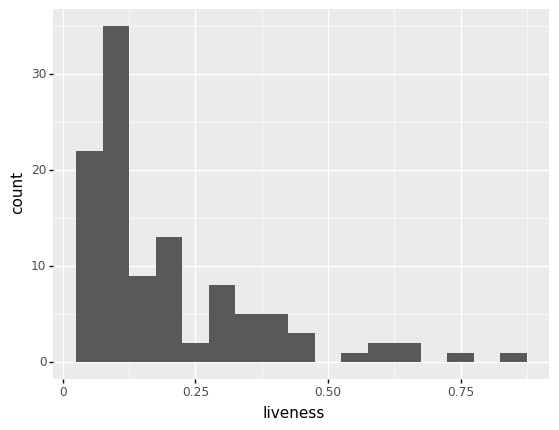

<ggplot: (8786844651442)>

In [7]:
ggplot(bowie_tracks, aes((bowie_tracks["liveness"]))) + geom_histogram(binwidth = 0.05)

As you can see, the distribution does not look very normal, which means it will be more difficult to train models on this metric. Instead, we can take the log of this value to improve the distribution and normalize this metric, turning it into a more typical bell shape:

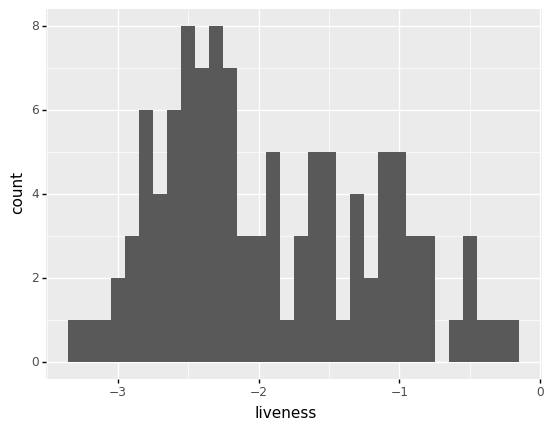

<ggplot: (8786844902434)>

In [8]:
ggplot(bowie_tracks, aes(np.log((bowie_tracks["liveness"])))) + geom_histogram(binwidth = 0.1)

That distribution looks much better, so we can add a new column to our dataframe incorperating this change

In [9]:
bowie_tracks["logLiveness"] = np.log(abs(bowie_tracks["liveness"]))

### Dataframe Summary 

Here are some summary stats for all of the numeric values in the database. I'm particularly interested in checking out the duration and popularity statistics.

In [25]:
bowie_tracks.describe().drop(columns=(['track_number'])).drop(['count', '25%', '50%','75%'])

,track_duration(s),danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,logLiveness
mean,236.841284,0.473517,0.591117,5.155963,-11.606202,0.055353,0.264087,0.104865,0.194670,0.529059,122.532569,47.211009,-1.929187
std,79.608518,0.125880,0.220069,3.699786,3.655194,0.040303,0.269171,0.256732,0.165186,0.245147,27.390334,11.630956,0.747496
min,60.500000,0.082300,0.022700,0.000000,-24.512000,0.026700,0.000051,0.000000,0.035800,0.036500,72.906000,30.000000,-3.329807
max,617.700000,0.786000,0.970000,11.000000,-4.968000,0.281000,0.964000,0.961000,0.831000,0.968000,206.357000,80.000000,-0.185125


The longest track that Bowie produced in the 70s is over 10 minutes long! That leads me to wonder what the sum of all the track durations is.

In [26]:
sum(bowie_tracks['track_duration(s)']) / 60 / 60

7.171027777777777

In total, Bowie produced over 7 hours of released music in the 70s

In [27]:
print("The new dataframe that we've created contains information on " 
      + str(len(bowie_tracks)) 
      + " songs that David Bowie produced in the 1970s. \n \nThe dataframe has "
      + str(len(bowie_tracks.columns)) 
      + " columns with information on the features of each track.")

The new dataframe that we've created contains information on 109 songs that David Bowie produced in the 1970s. 
 
The dataframe has 20 columns with information on the features of each track.


Lastly, I'd like to see if the column means stand out with any particular album. I can achieve this using the groupby() function in pandas.

In [31]:
album_stats = bowie_tracks.drop(columns=(['track_number','logLiveness'])).groupby("album_name")
album_stats.mean()

,track_duration(s),danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity
album_name,,,,,,,,,,,,
"""Heroes""",244.470000,0.417900,0.671800,4.400000,-9.718600,0.056350,0.199460,0.442574,0.143630,0.416980,116.218600,44.500000
Aladdin Sane,250.510000,0.435000,0.710500,6.500000,-8.775400,0.043140,0.139640,0.001437,0.134280,0.601200,131.633600,49.100000
Diamond Dogs,210.300000,0.400000,0.527455,5.454545,-14.976091,0.080436,0.505955,0.001901,0.443891,0.430091,126.662091,45.181818
Hunky Dory,228.300000,0.511545,0.301518,4.181818,-16.482636,0.041818,0.481345,0.000041,0.130955,0.431909,119.304182,56.909091
Lodger,209.820000,0.513100,0.684500,7.200000,-9.359400,0.058150,0.311622,0.100997,0.238910,0.679300,143.187400,36.200000
Low,213.127273,0.454664,0.633000,5.818182,-11.534364,0.052100,0.239918,0.515626,0.139300,0.495418,110.535000,46.909091
Pinups,170.308333,0.554500,0.688333,3.583333,-10.940083,0.048108,0.087480,0.010603,0.227025,0.645667,116.075750,35.000000
Station to Station,384.083333,0.573333,0.701667,5.833333,-11.174333,0.045883,0.164767,0.000553,0.123483,0.688833,109.584333,51.666667
The Man Who Sold the World,275.366667,0.355556,0.454667,5.222222,-13.343444,0.040300,0.323278,0.011242,0.127989,0.397111,131.417000,43.666667


While Bowie's most popular song from the 70s appears in the album "Heroes", the average popularity of the songs in an album are highest in "The Rise and Fall of Ziggy Stardust and the Spiders from Mars", which is something that I was not suprised to see!

### Loading Database Into a Local CSV or JSON file


Finally, we can write out this table locally as either a csv or json using the to_csv or to_json function respectively.

In [32]:
# Write out bowie track dataframe to project directory:
output = False
fileType = input("Would you like to export this file as a 'json' or 'csv' or 'both'?")

while output == False:
    
    if fileType == 'csv':
        bowie_tracks.to_csv(path_or_buf= "./bowie_70sSongs.csv", 
                         sep=',', 
                         na_rep='', 
                         float_format=None, 
                         columns=None, 
                         header=True, 
                         index=True, 
                         index_label=None, 
                         mode='w', 
                         quotechar='"', 
                         decimal='.', 
                         errors='strict', 
                         storage_options=None)
        output = True
        print("\nSuccessfully exported 'bowie_70sSongs.csv' to the project directory.")
        
    elif fileType == 'json':
        bowie_tracks.to_json(path_or_buf= "./bowie_70sSongs.json")
        output = True
        print("\nSuccessfully exported 'bowie_70sSongs.json' to the project directory.")
        
    elif fileType == 'both':
        bowie_tracks.to_csv(path_or_buf= "./bowie_70sSongs.csv", 
                         sep=',', 
                         na_rep='', 
                         float_format=None, 
                         columns=None, 
                         header=True, 
                         index=True, 
                         index_label=None, 
                         mode='w', 
                         quotechar='"', 
                         decimal='.', 
                         errors='strict', 
                         storage_options=None)
        bowie_tracks.to_json(path_or_buf= "./bowie_70sSongs.json")
        output = True
        print("\nSuccessfully exported 'bowie_70sSongs.csv' and 'bowie_70sSongs.json' to the project directory.")
        
    elif fileType == 'stop':
        print("\nExport canceled.")
        break
        
    else:
        fileType = input("You entered an invalid file type. Please enter either 'csv', 'json', 'both', or 'stop'")

Would you like to export this file as a 'json' or 'csv' or 'both'?both

Successfully exported 'bowie_70sSongs.csv' and 'bowie_70sSongs.json' to the project directory.
